<a href="https://colab.research.google.com/github/ThisDavidAdams/MMR-summarization/blob/main/MMR_Summarisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Clone WCEP Repository and install dependencies


In [2]:
!git clone https://github.com/gandharvsuri/wcep-mds-dataset
%cd wcep-mds-dataset

Cloning into 'wcep-mds-dataset'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 125 (delta 65), reused 89 (delta 37), pack-reused 0
Receiving objects: 100% (125/125), 1.09 MiB | 5.72 MiB/s, done.
Resolving deltas: 100% (65/65), done.
/content/wcep-mds-dataset


In [3]:
!pip install -r experiments/requirements.txt
!python -m nltk.downloader punkt

     |████████████████████████████████| 6.8MB 3.0MB/s 
     |████████████████████████████████| 1.6MB 23.2MB/s 
     |████████████████████████████████| 1.4MB 34.2MB/s 
  Cloning git://github.com/clic-lab/newsroom.git to /tmp/pip-install-3nu4ewki/newsroom
  Running command git clone -q git://github.com/clic-lab/newsroom.git /tmp/pip-install-3nu4ewki/newsroom
     |████████████████████████████████| 61kB 7.9MB/s 
     |████████████████████████████████| 184kB 37.8MB/s 
  Created wheel for nltk: filename=nltk-3.5-cp37-none-any.whl size=1434692 sha256=bd63c8d24e0a67989dc9ae0fbc7a832d19ce682f13fed245d468d9a4e024585d
  Stored in directory: /root/.cache/pip/wheels/ae/8c/3f/b1fe0ba04555b08b57ab52ab7f86023639a526d8bc8d384306
  Created wheel for newsroom: filename=newsroom-0.1-cp37-none-any.whl size=281701 sha256=da073ff3c10b9c31365aaeb17d42f0619dfdb0f12519eeaba3878ac1bdf8c06b
  Stored in directory: /tmp/pip-ephem-wheel-cache-4ad9ma9j/wheels/d5/c4/c7/23cd619d0c4202ef81a4509bfbaa6d90d89200c3ee15e518

## Download the test dataset

WCEP-100

In [4]:
!mkdir WCEP
!gdown https://drive.google.com/uc?id=1qsd5pOCpeSXsaqNobXCrcAzhcjtG1wA1 -O WCEP/test.jsonl.gz

Downloading...
From: https://drive.google.com/uc?id=1qsd5pOCpeSXsaqNobXCrcAzhcjtG1wA1
To: /content/wcep-mds-dataset/WCEP/test.jsonl.gz
51.5MB [00:01, 50.7MB/s]


In [5]:
import experiments.utils as utils

test_data = list(utils.read_jsonl_gz('WCEP/test.jsonl.gz'))
partial_test_data = test_data[:10] # for experimenting
print("Number of clusters:",len(test_data))
print(test_data[0].keys())

Number of clusters: 1022
dict_keys(['id', 'date', 'reference_urls', 'articles', 'summary', 'wiki_links', 'category'])


In [6]:
summary_max = 0
article_max = 0
for c in test_data:
  summary_max = max(summary_max,len(c['summary'].split(" ")))

  for a in c['articles']:
    if article_max < len(a['text'].split(" ")):
      long_text = a["text"]
    article_max = max(article_max,len(a['text'].split(" ")))

In [7]:
from statistics import mean

article_word_count = [len(a['text'].split()) for c in test_data for a in c["articles"]]
summary_word_count = [len(c['summary'].split()) for c in test_data]

print("max word count of articles:",max(article_word_count))
print("max word count of summary:",max(summary_word_count))
print("avg word count of articles:", int(mean(article_word_count)))
print("avg word count of summary:", int(mean(summary_word_count)))

max word count of articles: 13736
max word count of summary: 119
avg word count of articles: 403
avg word count of summary: 31


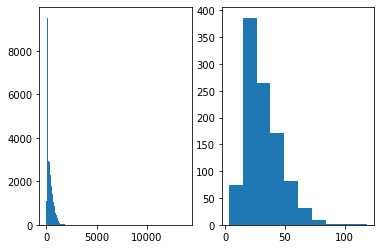

In [8]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)  
plt.hist(article_word_count, bins = 500)

plt.subplot(1, 2, 2)  
plt.hist(summary_word_count)
plt.show()

In [9]:
max_summary_length = 300
min_summary_length = 60

In [ ]:
c = test_data[0]
text = c["articles"][0]["text"]
summ = c["summary"]

## Importing the pretrained models

In [ ]:
!pip install torch
!pip install transformers
!pip install sentencepiece
!pip install spacy
!pip install bert-extractive-summarizer

In [ ]:
!python -m spacy download en_core_web_md

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
import warnings
warnings.filterwarnings("ignore")

#### Abstractive Models

In [ ]:
# PEGASUS

from transformers import PegasusForConditionalGeneration, PegasusTokenizer

class Pegasus():

  def __init__(self,device):
    self.name = "Pegasus"
    self.model_name = "google/pegasus-xsum"
    self.tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-xsum")
    self.device = device
    self.model = PegasusForConditionalGeneration.from_pretrained("google/pegasus-xsum").to(device)
  
  def summarise(self, text):
    inputs = self.tokenizer([text], max_length=512, truncation = True, return_tensors='pt')
    inputs.to(self.device)
    translated = self.model.generate(inputs['input_ids'],
                                        min_length=min_summary_length,
                                        max_length=max_summary_length,
                                        temperature=0.6,
                                        early_stopping=True,
                                        top_k = 50,
                                        no_repeat_ngram_size= 4,
                                    )
    
    summary = self.tokenizer.batch_decode(translated, skip_special_tokens=True)

    return summary[0]



In [ ]:
# T5

from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config

class T5():
  
  def __init__(self,device):
    self.name = "T5"
    self.device = device
    self.model = T5ForConditionalGeneration.from_pretrained('t5-large').to(device)
    self.tokenizer = T5Tokenizer.from_pretrained('t5-large')

  def summarise(self, text):
    text = "summarize: " + text
    tokenized_text = self.tokenizer.encode(text, return_tensors="pt", truncation = True).to(self.device)

    summary_ids = self.model.generate(tokenized_text,
                                        min_length=min_summary_length,
                                        max_length=max_summary_length,
                                        temperature=0.7,
                                        early_stopping=True,
                                        top_k = 50,
                                        no_repeat_ngram_size= 4,
                                      )
    
    summary = self.tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return summary


In [ ]:
# GPT2

from transformers import GPT2Tokenizer, GPT2LMHeadModel

class GPT2():

  def __init__(self,device):
    self.name = "GPT2"
    self.device = device
    self.model = GPT2LMHeadModel.from_pretrained("gpt2").to(self.device)
    self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

  def summarise(self,text):
    input_ids = self.tokenizer.encode(text, return_tensors = 'pt', truncation=True, max_length = 1020 - max_summary_length)
    tldr = self.tokenizer.encode(" TL;DR:", return_tensors = 'pt')
    input_ids = torch.cat((input_ids,tldr),-1)
    input_ids = input_ids.to(self.device)
    beam_output = self.model.generate(input_ids, 
                                      min_length = len(input_ids[0]) + min_summary_length,
                                      max_length=len(input_ids[0]) + max_summary_length,
                                      temperature=0.6,
                                      early_stopping=True,
                                      top_k = 50,
                                      no_repeat_ngram_size= 4,
                                    )
    output = self.tokenizer.decode(beam_output[0], skip_special_tokens=True)
    
    summary = output.split("TL;DR:")[-1]
    return summary

In [ ]:
# XLNet

from transformers import XLNetTokenizer, XLNetLMHeadModel

class XLNet():
  
  def __init__(self,device):
    self.name = "XLNet"
    self.device = device
    self.tokenizer = XLNetTokenizer.from_pretrained('xlnet-large-cased')
    self.model = XLNetLMHeadModel.from_pretrained('xlnet-large-cased').to(device)

  def summarise(self,text):
    input_ids = self.tokenizer.encode(text, return_tensors = 'pt', truncation=True, max_length = 1020 - max_summary_length)
    tldr = self.tokenizer.encode(" TL;DR:", return_tensors = 'pt')
    input_ids = torch.cat((input_ids,tldr),-1)
    input_ids = input_ids.to(self.device)
    beam_output = self.model.generate(input_ids,
                                      min_length=len(input_ids[0]) + min_summary_length,
                                      max_length=len(input_ids[0]) + max_summary_length,
                                      temperature=0.6,
                                      early_stopping=True,
                                      top_k = 50,
                                      no_repeat_ngram_size= 4,
                                    )
    
    output = self.tokenizer.decode(beam_output[0], skip_special_tokens=True)
    output = output.split("TL;DR:")[-1]
    return output
  

In [ ]:
# ProphetNet

from transformers import ProphetNetTokenizer, ProphetNetForConditionalGeneration

class ProphetNet():

  def __init__(self,device):
    self.name = "ProphetNet"
    self.device = device
    self.tokenizer = ProphetNetTokenizer.from_pretrained('microsoft/prophetnet-large-uncased')
    self.model = ProphetNetForConditionalGeneration.from_pretrained('microsoft/prophetnet-large-uncased').to(self.device)

  def summarise(self,text):
    input_ids = self.tokenizer(text, return_tensors="pt", truncation = True).input_ids
    decoder_input_ids = self.tokenizer("To summarise", return_tensors="pt").input_ids  
    input_ids = input_ids.to(self.device)
    decoder_input_ids = decoder_input_ids.to(self.device)

    beam_output = self.model.generate(input_ids, 
                                      decoder_input_ids = decoder_input_ids,
                                      min_length = min_summary_length,
                                      max_length = max_summary_length,
                                      temperature=0.7,
                                      early_stopping=True,
                                      top_k = 50,
                                      no_repeat_ngram_size= 4,
                                )
    
    output = self.tokenizer.decode(beam_output[0], skip_special_tokens=True)
    return output

In [ ]:
# BART

from transformers import BartTokenizer, BartForConditionalGeneration, BartConfig

class BART():

  def __init__(self,device):
    self.name = "BART"
    self.device = device
    self.model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn').to(device)
    self.tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

  def summarise(self, text, MDS = False):
    inputs = self.tokenizer([text], max_length=1024, truncation = True, return_tensors='pt').to(self.device)
    summary_ids = self.model.generate(inputs['input_ids'], 
                                      min_length = min_summary_length,
                                      max_length = max_summary_length,
                                      temperature=0.7,
                                      early_stopping=True,
                                      top_k = 50,
                                      no_repeat_ngram_size= 4,
                                    )
    
    return ' '.join([(self.tokenizer).decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids])

In [ ]:
# LED

from transformers import LEDTokenizer, LEDForConditionalGeneration, LEDConfig

class LED():

  def __init__(self,device):
    self.name = "LED"
    self.device = device
    self.model = LEDForConditionalGeneration.from_pretrained('allenai/led-base-16384').to(self.device)
    self.tokenizer = LEDTokenizer.from_pretrained('allenai/led-base-16384')

  def summarise(self, text, MDS = False):
    inputs = self.tokenizer([text], max_length=1024, truncation=True, return_tensors='pt').to(self.device)
    summary_ids = self.model.generate(inputs['input_ids'], 
                                      min_length = min_summary_length,
                                      max_length = max_summary_length,
                                      temperature=0.7,
                                      early_stopping=True,
                                      top_k = 50,
                                      no_repeat_ngram_size= 4,
                                    )
    return ' '.join([(self.tokenizer).decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids])

#### Extractive Models

In [ ]:
from transformers import AutoConfig, AutoTokenizer, AutoModel
from summarizer import Summarizer
# Pegasus extractive

class Pegasus_ext():
  
  def __init__(self):
    self.name = "PEGASUS EXT"
    model_name = "google/pegasus-xsum"
    custom_config = AutoConfig.from_pretrained(model_name)
    custom_config.output_hidden_states=True
    custom_tokenizer = AutoTokenizer.from_pretrained(model_name)
    custom_model = AutoModel.from_pretrained(model_name, config=custom_config)
    self.model = Summarizer(custom_model=custom_model, custom_tokenizer=custom_tokenizer)

  def summarise(self,text):
    return self.model(text,ratio = 0.4)
  

In [ ]:
# GPT2 extractive

class GPT2_ext():
  
  def __init__(self):
    self.name = "GPT2 EXT"
    model_name = "gpt2"
    custom_config = AutoConfig.from_pretrained(model_name)
    custom_config.output_hidden_states=True
    custom_tokenizer = AutoTokenizer.from_pretrained(model_name)
    custom_model = AutoModel.from_pretrained(model_name, config=custom_config)
    self.model = Summarizer(custom_model=custom_model, custom_tokenizer=custom_tokenizer)

  def summarise(self,text):
    return self.model(text,ratio = 0.4)

In [ ]:
# T5 extractive

class T5_ext():
  
  def __init__(self):
    self.name = "T5 EXT"
    model_name = "t5-large"
    custom_config = AutoConfig.from_pretrained(model_name)
    custom_config.output_hidden_states=True
    custom_tokenizer = AutoTokenizer.from_pretrained(model_name)
    custom_model = AutoModel.from_pretrained(model_name, config=custom_config)
    self.model = Summarizer(custom_model=custom_model, custom_tokenizer=custom_tokenizer)

  def summarise(self,text):
    return self.model(text,ratio = 0.4)

In [ ]:
# XLNet extractive

class XLNet_ext():
  
  def __init__(self):
    self.name = "XLNet EXT"
    model_name = "xlnet-large-cased"
    custom_config = AutoConfig.from_pretrained(model_name)
    custom_config.output_hidden_states=True
    custom_tokenizer = AutoTokenizer.from_pretrained(model_name)
    custom_model = AutoModel.from_pretrained(model_name, config=custom_config)
    self.model = Summarizer(custom_model=custom_model, custom_tokenizer=custom_tokenizer)

  def summarise(self,text):
    return self.model(text,ratio = 0.4)

In [ ]:
# BART extractive

class BART_ext():
  
  def __init__(self):
    self.name = "BART EXT"
    model_name = "facebook/bart-large-cnn"
    custom_config = AutoConfig.from_pretrained(model_name)
    custom_config.output_hidden_states=True
    custom_tokenizer = AutoTokenizer.from_pretrained(model_name)
    custom_model = AutoModel.from_pretrained(model_name, config=custom_config)
    self.model = Summarizer(custom_model=custom_model, custom_tokenizer=custom_tokenizer)

  def summarise(self,text):
    return self.model(text,ratio = 0.4)

In [ ]:
# LED extractive

class LED_ext():
  
  def __init__(self):
    self.name = "LED EXT"
    model_name = "allenai/led-base-16384"
    custom_config = AutoConfig.from_pretrained(model_name)
    custom_config.output_hidden_states=True
    custom_tokenizer = AutoTokenizer.from_pretrained(model_name)
    custom_model = AutoModel.from_pretrained(model_name, config=custom_config)
    self.model = Summarizer(custom_model=custom_model, custom_tokenizer=custom_tokenizer)

  def summarise(self,text):
    return self.model(text,ratio = 0.4)

## Generate Summaries

In [ ]:
%%time 

prophetnet = ProphetNet(device)
gpt2 = GPT2(device)
xlnet = XLNet(device)
t5 = T5(device)
led = LED(device)
bart = BART(device)
pegasus = Pegasus(device)

gpt2_ext = GPT2_ext()
xlnet_ext = XLNet_ext()
# t5_ext = T5_ext()
# led_ext = LED_ext()
bart_ext = BART_ext()
# pegasus_ext = Pegasus_ext()

In [ ]:
models = {
      "ProphetNet" : prophetnet,
      "GPT2" : gpt2,
      "T5" : t5,
      "XLNet" : xlnet,
      "LED" : led,
      "BART" : bart,
      "Pegasus" : pegasus,
      "GPT2 EXT": gpt2_ext,
      "XLNet EXT": xlnet_ext,
      "BART EXT": bart_ext,
}

In [ ]:
from experiments.evaluate import evaluate
from tqdm import tqdm 
import gc
from datetime import datetime
# Generating summaries

summaries = []
# summary keys : summary, type (MDS/SDS), index (None/article_index), model, clusterid, Rouge_score, MMR_reduced
for cluster in tqdm(partial_test_data):
  c = {} 
  c["cluster_id"] = cluster["id"]
  c["summaries"] = {}
  for i,article in enumerate(cluster['articles']):
    if i == 20:
        break
    
    c["summaries"][article["id"]] = []

  for _,model in models.items():
    for i,article in enumerate(cluster['articles']):
      
      #Clean up CUDA

      if i == 20:
        break
      gc.collect()
      torch.cuda.empty_cache()
      d = {}
      text = article["text"]
      if text == '':
        continue

      summary = model.summarise(text)
      
      d["type"] = "SDS"
      d["model"] = model.name

      text = None
      d["summary"] = summary

      rouge = evaluate([summary], [cluster["summary"]])
      summary = None
      d["rouge"] = rouge
      d["MMR_Reduced"] = None
      c["summaries"][article["id"]].append(d)

      d = None
      rouge = None
  
  summaries.append(c)

# save the progress
# now = datetime.now()
filename = "summaries.jsonl"
utils.write_jsonl(summaries, "/content/gdrive/MyDrive/ULETH/"+filename)

100%|██████████| 10/10 [1:42:13<00:00, 613.40s/it]


In [10]:
filename = "summaries.jsonl"
summaries = list(utils.read_jsonl("/content/gdrive/MyDrive/ULETH/"+filename))
print(len(summaries))

10


## Baseline models score

In [ ]:
summary_results = {}

model_names = set()

for d in summaries:
  for _, summ in d["summaries"].items():
    for s in summ:
      model_names.add(s["model"])

model_names = list(model_names)

for m in model_names:
  summary_results[m] = []

for d in summaries:
  for _, summ in d["summaries"].items():
    for s in summ:
      summary_results[s["model"]].append(s["rouge"])

In [ ]:
for model,scores in summary_results.items():
  r1 = []
  r2 = []
  rl = []

  for s in scores:
    r1.append(s["rouge-1"])
    r2.append(s["rouge-2"])
    rl.append(s["rouge-l"])
  
  r1p = mean([x['p'] for x in r1]) *100
  r1r = mean([x['r'] for x in r1]) *100
  r1f = mean([x['f'] for x in r1]) *100
  
  r2p = mean([x['p'] for x in r2]) *100
  r2r = mean([x['r'] for x in r2]) *100
  r2f = mean([x['f'] for x in r2]) *100
  
  rlp = mean([x['p'] for x in rl]) *100
  rlr = mean([x['r'] for x in rl]) *100
  rlf = mean([x['f'] for x in rl]) *100
  
  print(model)
  print("r1 p: {:.3f} r: {:.3f} f: {:.3f} \nr2 p: {:.3f} r: {:.3f} f: {:.3f} \nr2 p: {:.3f} r: {:.3f} f: {:.3f} \n".format(r1p,r1r,r1f,r2p,r2r,r2p,rlp,rlr,rlf))
  
  

## Setting up LDAMallet

In [11]:
!pip install gensim==3.8.3

     |████████████████████████████████| 24.2MB 1.3MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
# install JAVA
import os       
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.11" 2021-04-20
OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04)
OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)


In [ ]:
# Install Mallet
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2021-06-09 06:05:43--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  11.1MB/s    in 1.4s    

2021-06-09 06:05:45 (11.1 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classi

In [11]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel
from gensim import similarities

import os.path
import re
import glob

import nltk
nltk.download('stopwords')

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
os.environ['MALLET_HOME'] = 'mallet-2.0.8'
mallet_path = 'mallet-2.0.8/bin/mallet'

In [ ]:
def preprocess_data(doc_set,extra_stopwords = {}):
    # adapted from https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python
    # replace all newlines or multiple sequences of spaces with a standard space
    doc_set = [re.sub('\s+', ' ', doc) for doc in doc_set]
    doc_set = [doc.replace('\n', ' ') for doc in doc_set]
    doc_set = [doc.replace("'", "") for doc in doc_set]
    doc_set = [doc.replace('|||||', '') for doc in doc_set]

    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # add any extra stopwords
    if (len(extra_stopwords) > 0):
        en_stop = en_stop.union(extra_stopwords)
    
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # add tokens to list
        texts.append(stopped_tokens)
    return texts

def prepare_corpus(doc_clean):
    # adapted from https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [ ]:
number_of_topics=5 # adjust this to alter the number of topics
words=3

In [ ]:
import gc
from tqdm import tqdm
cluster_article_topic = []

for cluster in tqdm(partial_test_data):

  gc.collect()

  d = {}
  d["cluster_id"] = cluster["id"];
  d["topics"] = {}
  document_list = cluster['articles'][:20]
  document_id = [a["id"] for a in document_list]
  document_text = [a["text"] for a in document_list]
  doc_clean = preprocess_data(document_text,{})
  dictionary, doc_term_matrix = prepare_corpus(doc_clean)

  ldamallet = LdaMallet(mallet_path, corpus=doc_term_matrix, num_topics=number_of_topics, id2word=dictionary)
  gensimmodel = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

  del ldamallet

  document_topic_words = []
  for index in range(len(document_id)):
    document_topics = gensimmodel.get_document_topics(doc_term_matrix[0])
    document_topics = sorted(document_topics, key=lambda x: x[1], reverse=True) 

    topic_words = []
    for topic, prop in document_topics:
      topic_words += [word[0] for word in gensimmodel.show_topic(topic, 10)]
    
    document_topic_words.append(topic_words);

  id_words = zip(document_id, document_topic_words)

  for id,words in id_words:
    d["topics"][id] = words

  del gensimmodel
  cluster_article_topic.append(d)
  d = None

utils.write_jsonl(cluster_article_topic, "/content/gdrive/MyDrive/ULETH/topics.jsonl")

100%|██████████| 10/10 [05:09<00:00, 30.99s/it]


In [12]:
topics = list(utils.read_jsonl("/content/gdrive/MyDrive/ULETH/topics.jsonl"))
print(len(topics))

10


## MMR Setup

In [13]:
import gensim.downloader as api
import nltk
model = api.load('word2vec-google-news-300')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def process_word_movers_distance(document, query_document):
    document = preprocess(document)
    query_document = preprocess(query_document)
    distance = model.wmdistance(document, query_document)
    return distance

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [14]:
from nltk.tokenize import word_tokenize
import string
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stop_words = stopwords.words('english')

def preprocess(text):
    # Steps:
    # 1. lowercase
    # 2. Lemmatize. (It does not stem. Try to preserve structure not to overwrap with potential acronym).
    # 3. Remove stop words.
    # 4. Remove punctuations.
    # 5. Remove character with the length size of 1.

    lowered = str.lower(text)

    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(lowered)

    words = []
    for w in word_tokens:
        if w not in stop_words:
            if w not in string.punctuation:
                if len(w) > 1:
                    lemmatized = lemmatizer.lemmatize(w)
                    words.append(lemmatized)

    return words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
def compute_maximal_marginal_relevance(candidate_list, query, number_of_sentences=None, lambda_constant=0.5, sim = process_word_movers_distance):
    """
    Return ranked phrases using MMR. Cosine similarity is used as similarity measure.
    :param sim: similarity function to use for MMR
    :param query: Query sentence
    :param candidate_string: list of candidate sentences
    :param lambda_constant: 0.5 to balance diversity and accuracy. if lambda_constant is high, then higher similarity. If lambda_constant is low then high diversity.
    :param number_of_sentences: text from which to calculate the number of terms to include in result set
    :param threshold_terms: number of terms to include in result set
    :param tokenizer : tokemnizer
    :return: Ranked phrases with score
    """

    # candidate_list = tokenizer.tokenize(candidate_string)
    if not candidate_list or candidate_list is None or len(candidate_list) == 0:
        return ['']

    # if number_of_sentences is None or number_of_sentences > len(candidate_list):
    #   number_of_sentences = len(candidate_list)
    # Find best sentence to start
    initial_best_sentence = candidate_list[0]
    prev = float("-inf")

    for sent in candidate_list:
        similarity = sim(sent, query)
        if similarity != float("inf") and similarity > prev:
            initial_best_sentence = sent
            prev = similarity

    try:
        candidate_list.remove(initial_best_sentence)
    except ValueError:
        pass    # do nothing
    sentences_to_return = [initial_best_sentence]

    # Now find the prescribed number of best sentences
    for i in range(1, number_of_sentences):
        best_line = None
        previous_marginal_relevance = float("-inf")

        for sent in candidate_list:
            # Calculate the Marginal Relevance
            left_side = lambda_constant * sim(sent, query)
            right_values = [float("-inf")]
            for selected_sentence in sentences_to_return:
              similarity = sim(sent,selected_sentence)
              if similarity != float("inf"): 
                right_values.append(similarity)
            right_side = max(right_values) * (1 - lambda_constant)
            current_marginal_relevance = left_side - right_side

            # Maximize Marginal Relevance
            if current_marginal_relevance != float("inf") and current_marginal_relevance > previous_marginal_relevance:
                previous_marginal_relevance = current_marginal_relevance
                best_line = sent
        
        if best_line in candidate_list:
          sentences_to_return += [best_line]
          candidate_list.remove(best_line)

    return sentences_to_return

## MMR Reduction

In [ ]:
import experiments.sent_splitter as sent_splitter

sentSplitter = sent_splitter.SentenceSplitter()

for cluster in summaries:
  c = cluster["cluster_id"]
  cluster_topics = [x["topics"] for x in topics if x["cluster_id"] == c][0]

  for article_id, summ in cluster["summaries"].items():
    for info in summ:
      candidate_sents = sentSplitter.split_sents(info["summary"])
      query_doc = " ".join(cluster_topics[article_id])
    
      info["MMR_Reduced"] = compute_maximal_marginal_relevance(candidate_sents, query_doc)

filename = "summaries.jsonl"
utils.write_jsonl(summaries, "/content/gdrive/MyDrive/ULETH/"+filename)

In [ ]:
summaries = list(utils.read_jsonl("/content/gdrive/MyDrive/ULETH/summaries.jsonl"))

10

In [ ]:
summaries[0]

In [34]:
for cluster in summaries:
  f = open("summaries.txt","w")
  c = cluster["cluster_id"]
  d = {}
  d["cluster_id"] = c

  cluster_row = [x for x in partial_test_data if x["id"] == c][0]
  summary = cluster_row["summary"]

  for article_id,info in cluster["summaries"].items():
    a = [x["text"] for x in cluster_row["articles"] if x["id"] == article_id][0]

    f.write(a)
    f.write("\n"+"*"*30+"\n")
    f.write(summary)
    f.write("\n"+"*"*30+"\n")
    for summ in info:
      f.write(summ["model"])
      f.write("\n")
      f.write(str(summ["summary"]))
      f.write("\n\n\n")
  
    f.write("\n"+"-x-"*30+"\n")


In [37]:
from experiments.evaluate import evaluate
from tqdm import tqdm 
import gc

n = 20

goodmodels = ["LED", "BART", "T5", "Pegasus", "GPT2 EXT", "XLNet EXT", "BART EXT"]
final_summary_list = []
for cluster in tqdm(summaries):

  c = cluster["cluster_id"]
  d = {}
  d["cluster_id"] = c

  ground_summary = [x["summary"] for x in partial_test_data if x["id"] == c][0]
  
  candidate_sents = []
  for _,info in cluster["summaries"].items():
    for summ in info:
      if summ["model"] in goodmodels:
        candidate_sents += summ["MMR_Reduced"]
    
  query_doc = []  
  cluster_topics = [x["topics"] for x in topics if x["cluster_id"] == c][0]

  for article_id, info in cluster["summaries"].items():
    query_doc += cluster_topics[article_id]
    
  query_doc = " ".join(query_doc)
  # print(query_doc, "---\n")

  final_summary_sents = compute_maximal_marginal_relevance(candidate_sents, query_doc, number_of_sentences = n, lambda_constant= 0.7)
  print(final_summary_sents)
  final_summary = " ".join(final_summary_sents)
  
  # print(final_summary)
  d["rouge"] = evaluate([final_summary],[ground_summary])
  d["final_summary"] = final_summary

  final_summary_list.append(d)
  del final_summary
  del candidate_sents
  del query_doc

  gc.collect()

# print(final_summary_list[0])
filename = "finalsummaries.jsonl"
utils.write_jsonl(final_summary_list, "/content/gdrive/MyDrive/ULETH/"+filename)



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [11:00<1:39:01, 660.13s/it]

['"They were not injured.', '"They were not injured.', 'More than 200 people were injured in the blasts', 'More than 200 people were injured in the blasts', 'The police were also injured.', 'He prayed for early recovery of the injured.', 'He prayed for early recovery of the injured.', 'He prayed for early recovery of the injured.', 'He prayed for early recovery of the injured.', 'The van was damaged in the blast.', 'The vehicle was damaged in the blast.', 'The vehicle was damaged by the blast.', 'The vehicle was damaged in the blast.', 'The attack was carried out by a suicide bomber.', 'The attack was carried out by a suicide bomber.', 'Rescue operations are underway.', 'The death toll has risen to 20.', '"The blast may have been "a suicide attack', 'a suicide attack there in 2010 killed more than 40 people.', 'We are collecting forensic evidences to ascertain the nature of the blast.']
['Copyright 2019 The Associated Press.', 'This material may not be published, broadcast, rewritten o



 20%|██        | 2/10 [22:58<1:30:21, 677.72s/it]

['PHOTOS: Here he is!', 'PHOTOS: Here he is!', 'Photo credit: Chris Allerton ©?SussexRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyalRoyal



 30%|███       | 3/10 [35:04<1:20:43, 692.00s/it]

['Iran’', 'The Iranian', 'Such reactors produce plutonium that can be used in nuclear weapons.', 'Such reactors produce plutonium that can be used in nuclear weapons.', 'iran says it will not renegotiate the nuclear deal.', "That's compared to the 10,000 kilograms (22,046 pounds) of higher-enriched uranium it once had.", 'Under terms of the deal, Iran can keep a stockpile of no more than 300kg of low-enriched uranium, compared with 10,000kg of higher-enriched uranium it once had.', 'Under terms of the deal, Iran can keep a stockpile of no more than 300kg of low-enriched uranium, compared with 10,000kg of higher-enriched uranium it once had.', "How the sanctions will affect Iran's miners remains unclear.", "How the sanctions will affect Iran's miners remains unclear.", "How the sanctions will affect Iran's miners remains unclear.", 'Under terms of the deal, Iran can keep a stockpile of no more than 300 kilograms (660 pounds) of low-enriched uranium.', 'Under terms of the deal, Iran can 



 40%|████      | 4/10 [53:15<1:21:10, 811.68s/it]

['"We did not substantiate any of the allegations.', '"We did not substantiate any of the allegations.', '"We did not substantiate any of the allegations.', 'They’re saying there is enough evidence to indict.', 'They’re saying there is enough evidence to indict.', 'zelizer: if the president refuses to cooperate, the only remedy is impeachment.', 'Opinion: More than 700 prosecutors say there is enough evidence to charge the president with felonies.', 'Opinion: More than 700 prosecutors say there is enough evidence to charge the president with felonies.', 'Opinion: More than 700 prosecutors say there is enough evidence to charge the president with felonies.', 'Opinion: More than 700 prosecutors say there is enough evidence to charge the president with felonies.', "president has been a proponent of president jair bolivaro's.", '"That\'s not a hypothesis we\'re considering.', '"That\'s not a hypothesis we\'re considering.', '"That\'s not a hypothesis we\'re considering.', '"That\'s not a h



 50%|█████     | 5/10 [1:05:58<1:06:26, 797.25s/it]

['the dispute has rumbled on for centuries.', 'Guatemalans voted in 2018 to have the ICJ rule on the dispute.', 'Guatemalans voted in 2018 to have the ICJ rule on the dispute.', 'dispute dates back to colonial era.', 'dispute dates back to colonial era.', 'The dispute dates back to the colonial era.', 'dispute dates back to colonial era and has raged for decades.', 'The dispute dates back to the Spanish colonial era.', 'The dispute dates back to the Spanish colonial era.', 'The dispute dates back to the Spanish colonial era.', 'The dispute dates back to the Spanish colonial era.', 'dispute stretches back to the dawn of the colonial era in the Americas.', 'dispute stretches back to dawn of the colonial era in the Americas.', 'The dispute stretches back to the dawn of the colonial era in the Americas.', 'dispute stretches back to dawn of the colonial era in the Americas.', 'The dispute stretches back to the dawn of the colonial era in the Americas.', 'dispute stretches back to dawn of th



 60%|██████    | 6/10 [1:16:41<50:04, 751.04s/it]  

['These are the soldiers against extremism.', 'These are the soldiers against extremism.', 'These are the soldiers against extremism.', 'She was sentenced to death in 2013.', 'She was sentenced to death in 2013.', 'She was sentenced to death in 2013.', 'She was sentenced to death in 2013.', 'Her husband is paralyzed from the waist down, having', '“ Her husband is paralyzed from the waist down, having fractured his spine in a 2004 accident.', 'Her husband is paralyzed from the waist down, having fractured his spine in a 2004 accident.', 'Her husband is paralyzed from the waist down, having fractured his spine in a 2004 accident.', 'She was released on bail in January.', 'She was sentenced to execution by hanging.', 'She was sentenced to execution by hanging.', 'She was released on bail in October.', 'she was convicted of blasphemy in 2009 after a quarrel with a fellow farmworker.', 'Pakistan’s interior and', 'Bibi was convicted in 2009 of insulting Islam’s prophet.', 'She is believed to



 70%|███████   | 7/10 [1:28:26<36:51, 737.23s/it]

['Transcript for Transcript for Transcript for Transcript for Transcript for Transcript for Transcript for Transcript for Transcript for', 'REUTERS/Brendan McDermid/File Photo', 'Copyright (c) The Vancouver Sun E-mail this Article Print this Article', 'We are committed to truth and accuracy in all of our journalism.', 'We are committed to truth and accuracy in all of our journalism.', 'Copyright 2019 The Associated Press.', '"It was an unfair, whiny complaint.', '"we did not relish doing this.', 'We did not relish doing this.', '"Bob Mueller is no friend of mine.', '"Bob Mueller is no friend of mine.', 'material may not be published, broadcast or redistributed.', 'This material may not be published, broadcast, rewritten or redistributed.', 'This material may not be published, broadcast, rewritten or redistributed.', 'This material may not be published, broadcast, rewritten or redistributed.', "That he can't legally have that stuff.", '"Bob Mueller is no friend of mine," he says.', 'But



 80%|████████  | 8/10 [1:42:03<25:22, 761.08s/it]

['The subpoena is for Don Jr.', 'Trump Jr', 'Trump Jr', "it's unclear if Trump Jr. will comply with the subpoena.", "It's unclear if Trump Jr. will comply with the subpoena.", "It's unclear if Trump Jr. will comply with the subpoena.", "it's unclear if Trump Jr. will comply with the subpoena.", "it's unclear if Trump Jr. will comply with the subpoena.", "It's unclear if Trump Jr. will comply with the subpoena.", "It's unclear if Trump Jr. will comply with the subpoena.", "it's unclear if Trump Jr. will comply with the subpoena.", "It's unclear if Trump Jr. will comply with the subpoena.", 'Alan Futerfas, a lawyer for Trump Jr., declined to comment on the subpoena.', 'Alan Futerfas, a lawyer for Trump Jr., declined to comment on the subpoena.', 'Alan Futerfas, a lawyer for Trump Jr., declined to comment on the subpoena.', 'Alan Futerfas, a lawyer for Trump Jr., declined to comment on the subpoena.', 'Alan Futerfas, a lawyer for Trump Jr., declined to comment on the subpoena.', 'Alan Fut



 90%|█████████ | 9/10 [1:57:07<13:24, 804.03s/it]

['Voters cast ballots for', 'About 26.8million voters are registered to cast their ballots at 22,925 polling stations countrywide.', 'About 26.8million voters are registered to cast their ballots at 22,925 polling stations countrywide.', 'About 26.8million voters are registered to cast their ballots at 22,925 polling stations countrywide.', 'In 1994, 86 per cent of the eligible voters cast their vote.', 'In 1994, 86 per cent of the eligible voters cast their vote.', 'So, what are the stakes here in this election?', 'So, what are the stakes here in this election?', 'So, what are the stakes here in this election?', 'He chose competent technocrats as replacements.', 'He chose competent technocrats as replacements.', 'He chose competent technocrats as replacements.', 'How can an actor be punished for playing a thief role in a movie?', 'How can an actor be punished for playing a thief role in a movie?', '“ To register and learn more about the topics, speakers and programme, please visit the



100%|██████████| 10/10 [2:06:51<00:00, 761.13s/it]


In [40]:
filename = "finalsummaries.jsonl"
utils.write_jsonl(final_summary_list, "/content/gdrive/MyDrive/ULETH/"+filename)

In [41]:
final_summary_list = list(utils.read_jsonl("/content/gdrive/MyDrive/ULETH/finalsummaries.jsonl"))
final_summary_list[0]

{'cluster_id': 70114,
 'final_summary': '"They were not injured. "They were not injured. More than 200 people were injured in the blasts More than 200 people were injured in the blasts The police were also injured. He prayed for early recovery of the injured. He prayed for early recovery of the injured. He prayed for early recovery of the injured. He prayed for early recovery of the injured. The van was damaged in the blast. The vehicle was damaged in the blast. The vehicle was damaged by the blast. The vehicle was damaged in the blast. The attack was carried out by a suicide bomber. The attack was carried out by a suicide bomber. Rescue operations are underway. The death toll has risen to 20. "The blast may have been "a suicide attack a suicide attack there in 2010 killed more than 40 people. We are collecting forensic evidences to ascertain the nature of the blast.',
 'rouge': {'rouge-1': {'f': 0.069, 'p': 0.273, 'r': 0.04},
  'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0},
  'rouge-l': {

In [44]:
r1 = []
r2 = []
rl = []  

for c in final_summary_list:
  rouge = c["rouge"]
  r1.append(rouge['rouge-1'])
  r2.append(rouge['rouge-2'])
  rl.append(rouge['rouge-l'])

r1p = mean([x['p'] for x in r1]) *100
r1r = mean([x['r'] for x in r1]) *100
r1f = mean([x['f'] for x in r1]) *100

r2p = mean([x['p'] for x in r2]) *100
r2r = mean([x['r'] for x in r2]) *100
r2f = mean([x['f'] for x in r2]) *100

rlp = mean([x['p'] for x in rl]) *100
rlr = mean([x['r'] for x in rl]) *100
rlf = mean([x['f'] for x in rl]) *100

print("r1 p: {:.3f} r: {:.3f} f: {:.3f} \nr2 p: {:.3f} r: {:.3f} f: {:.3f} \nrl p: {:.3f} r: {:.3f} f: {:.3f} \n".format(r1p,r1r,r1f,r2p,r2r,r2p,rlp,rlr,rlf))

r1 p: 34.550 r: 5.000 f: 8.530 
r2 p: 5.450 r: 0.670 f: 5.450 
rl p: 24.970 r: 3.430 f: 5.890 



In [ ]:
for model,scores in summary_results.items():
  r1 = []
  r2 = []
  rl = []

  for s in scores:
    r1.append(s["rouge-1"])
    r2.append(s["rouge-2"])
    rl.append(s["rouge-l"])
  
  r1p = mean([x['p'] for x in r1]) *100
  r1r = mean([x['r'] for x in r1]) *100
  r1f = mean([x['f'] for x in r1]) *100
  
  r2p = mean([x['p'] for x in r2]) *100
  r2r = mean([x['r'] for x in r2]) *100
  r2f = mean([x['f'] for x in r2]) *100
  
  rlp = mean([x['p'] for x in rl]) *100
  rlr = mean([x['r'] for x in rl]) *100
  rlf = mean([x['f'] for x in rl]) *100
  
  print(model)
  print("r1 p: {:.3f} r: {:.3f} f: {:.3f} \nr2 p: {:.3f} r: {:.3f} f: {:.3f} \nr2 p: {:.3f} r: {:.3f} f: {:.3f} \n".format(r1p,r1r,r1f,r2p,r2r,r2p,rlp,rlr,rlf))

## Generate Summaries

In [ ]:
from experiments.evaluate import evaluate
from tqdm import tqdm 
import pickle

# Generating summaries

summaries = []
# summary keys : summary, type (MDS/SDS), index (None/article_index), model, clusterid, Rouge_score, MMR_reduced

for cluster in tqdm(test_data):

  # MDS
  for model in MDS_models:
    d = {}

    d["type"] = "MDS"
    d["model"] = model
    d["index"] = None
    d["clusterId"] = clusterId

    summary = MDS_models[model](cluster['articles'])
    d["summary"] = summary

    d["rouge"] = evaluate([summary], [cluster["summary"]])
    d["MMR_reduced"] = None
    summaries.append(d)
  
  # SDS
  for model in SDS_models:
    for article in cluster['articles']:
      d = {}

      d["type"] = "SDS"
      d["model"] = model
      d["index"] = article["id"]
      d["clusterId"] = clusterId

      summary = SDS_models[model](article)
      d["summary"] = summary

      d["rouge"] = evaluate([summary], [cluster["summary"]])
      d["MMR_reduced"] = None
      summaries.append(d)

# save the progress
utils.write_jsonl(summaries, "/content/gdrive/MyDrive/ULETH/summaries.jsonl")

In [ ]:
summaries = list(utils.read_jsonl("/content/gdrive/MyDrive/ULETH/summaries.jsonl"))

## MMR

In [ ]:
import experiments.sent_splitter as sent_splitter

sentSplitter = sent_splitter.SentenceSplitter()

# MMR 1
for summ in summaries:

  text = summ["summary"]
  sentences = sentSplitter(text)

  # MMR
  output = None # MMR ranked - least diverse
  summ["MMR_reduced"] = output

# save the progress
utils.write_jsonl(summaries, "summaries.jsonl")

In [ ]:
summaries = list(utils.read_jsonl("summaries.jsonl"))

clusters = [c["clusterId"] for c in summaries]
clusters = list(set(clusters))

## Final Summaries

In [ ]:
# Generating final summary
# MMR 2

final_summaries = []

for cid in clusters:
  d = {}
  d["clusterId"] = cid

  cluster_summaries = [c for c in summaries if cid = c["clusterId"]]
  ground_truth = [c["summary"] for c in test_data where c["id"] == cid][0]

  cluster_sentences = []
  for summ in cluster_summaries:

    text = summ["MMR_reduced"]
    sentences = sentSplitter(text)

    cluster_sentences.extend(sentences)


  # MMR 

  # pick top n sentences
  final_summary = ' '.join(topn_sentences)
  Rouge_score = evaluate([final_summary], [ground_truth])

  d["summary"] = final_summary
  d["rouge"] = Rouge_score


  final_summaries.append(d)

# save the progress  
utils.write_jsonl(final_summaries, "finalsummaries.jsonl")